In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
base_dataset = pd.read_hdf('/home/dissertation/data/base_abt.h5', 'base_abt')

base_dataset['city'] = base_dataset.city.astype(str)
base_dataset['registered_via'] = base_dataset.registered_via.astype(str)

## Simple Data Prep 
base_dataset = base_dataset.drop(labels =['gender','msno'], axis=1)

## Simply drops records with NA 
base_dataset = clean_dataset(base_dataset)

print(base_dataset.shape)
base_dataset.head()

(858935, 19)


,is_churn,city,bd,registered_via,registration_init_time,registration_init_time_dt,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,transaction_date_min,transaction_date_max,cancel_times
0,1,5,28,3,20131223,2013-12-23,6,31.00,2.00,0.00,10.00,49.67,298.00,149.00,894.00,True,20150331.00,20170228.00,1
1,1,13,20,3,20131223,2013-12-23,5,38.00,3.00,30.00,25.40,125.40,627.00,125.40,627.00,False,20160303.00,20170210.00,0
2,1,13,18,3,20131227,2013-12-27,18,38.00,1.00,30.00,30.00,149.00,2682.00,149.00,2682.00,False,20150819.00,20170130.00,0
3,1,1,0,7,20140109,2014-01-09,19,41.00,2.00,30.00,25.63,125.47,2384.00,141.16,2682.00,True,20150108.00,20160225.00,3
4,1,13,35,7,20140125,2014-01-25,24,41.00,1.00,30.00,26.25,105.38,2529.00,123.17,2956.00,True,20150124.00,20160901.00,2


In [4]:
RANDOM_STATE = 42 
CV_ITER = 3
SCORING_METRIC = None

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB', GaussianNB(), {}, SCORING_METRIC),
    ('DT', DecisionTreeClassifier(), {}, SCORING_METRIC),
    ('RF', RandomForestClassifier(), {}, SCORING_METRIC),
    ('LR', LogisticRegression(solver = 'liblinear'), {}, SCORING_METRIC),
    ('AB', AdaBoostClassifier(), {}, SCORING_METRIC),
    ('MLP', MLPClassifier(), {}, SCORING_METRIC)
]

In [5]:
all_metrics = pd.DataFrame()
all_metrics

""


In [41]:
sample_dataset = base_dataset.sample(50000)

In [8]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


PRE-SAMPLING: (35000, 18) (35000,) Counter({0: 31751, 1: 3249})
POST-SAMPLING: (35000, 18) (35000,) Counter({0: 31751, 1: 3249})
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via']
Categorical columns in dataset ['city', 'registered_via']
X_train:  (35000, 40) (35000, 1)
X_test:  (15000, 40) (15000, 1)


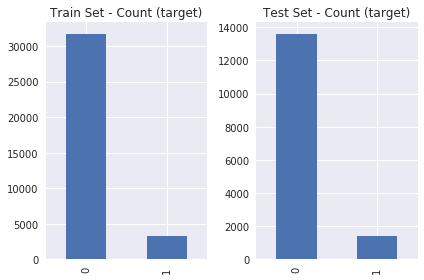

In [42]:
X_train, X_test, y_train, y_test = \
            prepare_train_test_split(sample_dataset, 
                                     sample_dataset.columns.get_loc("is_churn"), 
                                     sampler = DummySampler(), 
                                     split_ratio = 0.7, 
                                     r_state = RANDOM_STATE,
                                     cat_col = ['city','registered_via'])

plt.subplot(1, 2, 1)
y_train.is_churn.value_counts().plot(kind='bar', title='Train Set - Count (target)')
plt.subplot(1, 2, 2)
y_test.is_churn.value_counts().plot(kind='bar', title='Test Set - Count (target)')
plt.tight_layout()
plt.show()

In [ ]:
%%time
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=int(3600*4), n_jobs=8)
automl.fit(X_train.drop(columns=['registration_init_time', 'registration_init_time_dt'], axis=1), 
           y_train,
          metric = autosklearn.metrics.recall)

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector 

[WARNING] [2019-07-17 17:30:01,516:EnsembleBuilder(1791095845):c71ddd0151c1ede9558f3924127198f5] No models better than random - using Dummy Score!
[WARNING] [2019-07-17 17:30:01,526:EnsembleBuilder(1791095845):c71ddd0151c1ede9558f3924127198f5] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-07-17 17:31:56,742:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-07-17 17:31:56,742:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

In [ ]:
y_hat = automl.predict(X_test.drop(columns=['registration_init_time', 'registration_init_time_dt'], axis=1))

In [ ]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))
print("Recall score", sklearn.metrics.recall_score(y_test, y_hat))
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
automl.sprint_statistics()

### Experiment 1.1 Baseline - Default Settings - No sampling

In [ ]:
%%time

sampler = ('None', DummySampler())

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics.sort_values('f1_score', ascending=False)

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,12,13], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics = perform_experiment(base_dataset[cols], classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER)

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics.sort_values('aucroc', ascending=False).head(15)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)